# DP 2: Code
By Conan Zhang and Tamer Saatci

This notebook details all the code used to design, simulate, test, and plot our control system for the differential-drive robot in artificial gravity. The system consists of a chassis (light blue), a left wheel (orange), and a right wheel (orange). The robot is considered “differential-drive” because two separate motors allow a different torque to be applied to the left and right wheel. The picture below illustrates the robot (a segbot) and its variables that describe its dynamic motion. The goal is to implement a controller that applies torque to the wheels of the segbot keeping it upright, while directing it in the rotating space station. 

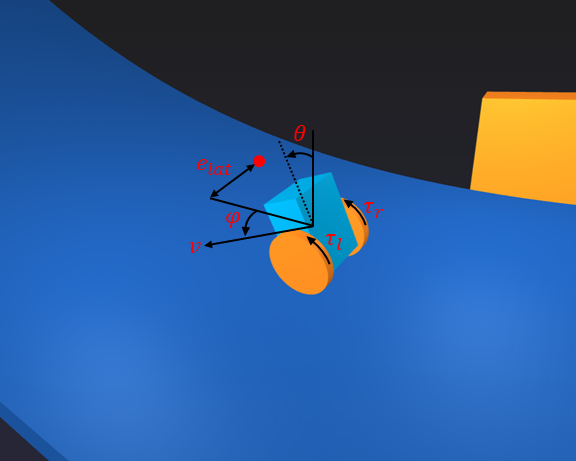

# System Dynamics and Equations of Motion

The first step to take is to import all the packages needed. Numpy, Sympy, Scipy help with matrix manipulation and finding our eigenvalues. They are also necessary deriving the equations of motion of the system using the approach given in [Tuttle, 2014](https://docs.lib.purdue.edu/cgi/viewcontent.cgi?article=1415&context=open_access_theses). The PyBullet enviornment is imported from the ae353_segbot module used to simulate, render, and plot a segbot dynamic system. Plots are created using matplotlib.pyplot. 

In [180]:
# All Imports
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import ae353_segbot
from sympy import N as N_sympy
from scipy import signal, linalg
np.set_printoptions(suppress=True) #This disables scientific notation
init_printing() # This function makes the outputs of SymPy look neater and easier to read

Next the system constants must be defined:

In [181]:
# Constants of the system
m_c = 12.0    # Mass of the chassis in kg
ixx_c = 1.0   # Roll mass moment of ineria of the chassis
iyy_c = 0.8   # Pitch mass moment of interia of the chassis
izz_c = 0.52  # Yaw mass moment of interia of the chassis

m_w = 1.2       # Mass of either wheel in kg
iaa_w = 0.0634  # Axial mass moment of interia of the wheels
itt_w = 0.0327  # Transverse mass moment of interia of the wheels
r_w = 0.325     # Radius of either wheel in meters

m = m_c + 2*m_w        # The total mass of the system
ixx = ixx_c + 2*itt_w  # The total roll mass moment of inertia of the system
iyy = iyy_c            # The total pitch mass moment of inertia of the system
izz = izz_c + 2*itt_w  # The total yaw mass moment of inertia of the system

h = 0.2   # Distance from the CoM of the chassis to wheel axle in meters
a = 0.35  # Half the distance between the wheels in meters

r_station = 20.0  # The radius of the station in meters
v_station = -0.1  # The angular velocity of the station in rad/second

Now the symbols (variables) and functions must be created:

In [182]:
# System's generalized coordinates 
e_lat = Symbol('e_lat')          # The lateral error of the segbot. Positive is to the left of the target position.
phi = Symbol('phi')              # The yaw of the chassis of the segbot relative to the station. Positive is facing left.
phidot = Symbol('phidot')        # The yawing velocity of the segbot relative to the station. Positive is turning left.
v = Symbol('v')                  # The forward velocity of the segbot. Positive is moving forward.
theta = Symbol('theta')          # The pitch of the chassis of the segbot. Positive is tipped forwards.
thetadot = Symbol('thetadot')    # The pitching velocity of the segbot. Positive is tipping forward.
tau_l = Symbol('tau_l')          # The torque applied to the left wheel of the segbot. Positive moves the segbot forward.
tau_r = Symbol('tau_r')          # The torque applied to the right wheel of the segbot. Positive moves the segbot forward.

Now applying the method given in [Tuttle, 2014](https://docs.lib.purdue.edu/cgi/viewcontent.cgi?article=1415&context=open_access_theses), the full equation of motions can be seen below:

In [183]:
M = Matrix([[m + 2 * iaa_w / r_w**2, 0, m_c * h * cos(theta)],
            [0, (ixx + m_c * h**2) * sin(theta)**2 + izz * cos(theta)**2 + (2 * iaa_w * a**2 / r_w**2) + 2 * m_w * a**2, 0],
            [m_c * h * cos(theta), 0, iyy * m_c * h**2]])
N = Matrix([[m_c * h * (phidot**2 + thetadot**2) * sin(theta)],
            [-2 * (ixx - izz + m * h**2) * cos(theta) * sin(theta) * phidot * thetadot - m_c * h * sin(theta) * v * phidot],
            [(ixx - izz + m_c * h**2) * cos(theta) * sin(theta) * phidot**2 + m_c * 9.81 * h * sin(theta)]])
R = Matrix([[1 / r_w, 1 / r_w],
            [-a / r_w, a / r_w],
            [-1, -1]])
f_partial = simplify(M.inv() * (N + R * Matrix([[tau_l], [tau_r]])))
f = Matrix([[v * sin(phi)],
            [f_partial]])
f = simplify(f)
N_sympy(f,3) # This rounds floating point number to 3 places and then prints to the screen

⎡                                                  v⋅sin(φ)                   
⎢                                                                             
⎢                               ⎛ 2    2⎞               ⎛      2              
⎢     -18.4⋅τₗ - 18.4⋅τᵣ - 14.4⋅⎝φ̇  + θ̇ ⎠⋅sin(θ) + 37.4⋅⎝0.48⋅φ̇ ⋅sin(2⋅θ) -
⎢     ────────────────────────────────────────────────────────────────────────
⎢                                                     2                       
⎢                                             89.9⋅cos (θ) - 93.5             
⎢                                                                             
⎢                           -1.06⋅φ̇⋅θ̇⋅sin(2⋅θ) - 2.4⋅φ̇⋅v⋅sin(θ) - 1.08⋅τₗ +
⎢                           ──────────────────────────────────────────────────
⎢                                                     2                       
⎢                                             0.96⋅sin (θ) + 1.03             
⎢                                                   

# System Linearization and State Space Form

Beginning the linearization process, two variables omega_phi and omega_theta are substituted into the equations of motion to turn everything into first order differential equations. Thus, two more state variables must be added to the system to account for the two new replacement variables. The system model is now:

$$
\begin{bmatrix}
\dot{e_{lat}} \\
\dot{v} \\
\dot{\omega_{\phi}} \\
\dot{\omega_{\theta}} \\
\dot{\theta} \\
\dot{\phi} \\
\end{bmatrix} = f(e_{lat}, v, \phi, \omega_{\phi}, \theta, \omega_{\theta}, \tau_l, \tau_r)
$$

In [184]:
#setting up the two replacement variables
omega_phi, omega_theta = symbols('omega_phi, omega_theta')
f = f.subs({phidot: omega_phi, thetadot: omega_theta})

#generating the new function
f = Matrix([f[0],
            f[1],
            f[2],
            f[3],
            omega_theta,
            omega_phi])
N_sympy(f,3)

⎡                                                      v⋅sin(φ)               
⎢                                                                             
⎢                               ⎛  2         2⎞               ⎛       2       
⎢     -18.4⋅τₗ - 18.4⋅τᵣ - 14.4⋅⎝ωᵩ  + ωₜₕₑₜₐ ⎠⋅sin(θ) + 37.4⋅⎝0.48⋅ωᵩ ⋅sin(2⋅
⎢     ────────────────────────────────────────────────────────────────────────
⎢                                                        2                    
⎢                                                89.9⋅cos (θ) - 93.5          
⎢                                                                             
⎢                           -1.06⋅ωᵩ⋅ωₜₕₑₜₐ⋅sin(2⋅θ) - 2.4⋅ωᵩ⋅v⋅sin(θ) - 1.08⋅
⎢                           ──────────────────────────────────────────────────
⎢                                                        2                    
⎢                                                0.96⋅sin (θ) + 1.03          
⎢                                                   

Choosing desirable equilibrium points of 0 asides from the segbot velocity = 0.4, the controller can stabilize around a non-moving velocity. The equilibrium points chosen indeed work as the function is entirely equal to zero after plugging the points in.

In [185]:
#equilibrium points chosen:
omega_theta_e = 0
omega_phi_e = 0
theta_e= 0
phi_e = 0
tau_l_e = 0
tau_r_e = 0
v_e = 0.4
e_lat_e = 0

#testing the equilibrium points, the chosen points work!
f_num = lambdify([e_lat, v, phi, omega_phi, theta, omega_theta, tau_l, tau_r], f)

equilibrium = f_num(e_lat_e, v_e, omega_phi_e, omega_theta_e, theta_e, phi_e, tau_l_e, tau_r_e)
print(equilibrium)

[[ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]]


Solving for the A and B matrices by taking the Jacobian of the function with respect to the state and input variables, A is a 6x6 matrix and B is a 6x2 matrix. The system is now placed into state-space form

In [186]:
A_num = lambdify([e_lat, v, omega_phi, omega_theta, theta, phi, tau_l, tau_r], f.jacobian([e_lat, v, omega_phi, omega_theta, theta, phi]))
A = A_num(e_lat_e, v_e, omega_phi_e, omega_theta_e, theta_e, phi_e, tau_l_e, tau_r_e).astype(float)
Matrix(A)

⎡0  0   0    0          0          0.4⎤
⎢                                     ⎥
⎢0  0   0    0   -245.05666141112   0 ⎥
⎢                                     ⎥
⎢0  0   0    0          0           0 ⎥
⎢                                     ⎥
⎢0  0   0    0   1592.91663381946   0 ⎥
⎢                                     ⎥
⎢0  0   0   1.0         0           0 ⎥
⎢                                     ⎥
⎣0  0  1.0   0          0           0 ⎦

In [187]:
B_num = lambdify([e_lat, v, omega_phi, omega_theta, theta, phi, tau_l, tau_r], f.jacobian([tau_l, tau_r]))
B = B_num(e_lat_e, v_e, omega_phi_e, omega_theta_e, theta_e, phi_e, tau_l_e, tau_r_e).astype(float)
Matrix(B)

⎡        0                  0        ⎤
⎢                                    ⎥
⎢15.5326172644859   15.5326172644859 ⎥
⎢                                    ⎥
⎢-1.04916430028236  1.04916430028236 ⎥
⎢                                    ⎥
⎢-99.6830245697012  -99.6830245697012⎥
⎢                                    ⎥
⎢        0                  0        ⎥
⎢                                    ⎥
⎣        0                  0        ⎦

# Gain Selection and Controllability

Using LQR method to find the optimal eigenvalues and a gain matrix with the given weights, the Q and R matrices can be seen below. Pitch angle is weighted 1000 more times than the other variables, while pitch rate and yaw rate are weighted 10 times more than the other variables. This design choice came about after extensive testing and simulations. Pitch angle is determined to be the most crucial factor in keeping our segbot upright while meeting its desired requirements.

In [188]:
Q = np.diag([0.1,0.1,1,1,100,0.1])
R = np.diag([0.1, 0.1])
Matrix(Q)

⎡0.1   0    0    0     0     0 ⎤
⎢                              ⎥
⎢ 0   0.1   0    0     0     0 ⎥
⎢                              ⎥
⎢ 0    0   1.0   0     0     0 ⎥
⎢                              ⎥
⎢ 0    0    0   1.0    0     0 ⎥
⎢                              ⎥
⎢ 0    0    0    0   100.0   0 ⎥
⎢                              ⎥
⎣ 0    0    0    0     0    0.1⎦

In [189]:
Matrix(R)

⎡0.1   0 ⎤
⎢        ⎥
⎣ 0   0.1⎦

In [190]:
P = linalg.solve_continuous_are(A, B, Q, R) #continuous-time algebraic Riccati equation for a P matrix
K = linalg.inv(R) @  B.T @ P 
Matrix(K)

⎡-0.707106781186554  -0.707106781186873  -2.51425784617885  -2.41946016893967 
⎢                                                                             
⎣0.707106781186548   -0.707106781186802  2.51425784617884   -2.41946016893966 

 -31.9611994640698  -1.38646277200207⎤
                                     ⎥
 -31.9611994640698  1.38646277200205 ⎦

The system is asymptotically stable if and only if all eigenvalues have a negative real part. They are all negative as seen below:

In [191]:
Matrix(linalg.eigvals(A - B @ K)) #finds the system's eigenvalues

⎡           -449.768367401201            ⎤
⎢                                        ⎥
⎢           -4.68136656915385            ⎥
⎢                                        ⎥
⎢-0.297186289338721 + 0.196109352395337⋅ⅈ⎥
⎢                                        ⎥
⎢-0.297186289338721 - 0.196109352395337⋅ⅈ⎥
⎢                                        ⎥
⎢           -10.5295914693876            ⎥
⎢                                        ⎥
⎣           -0.09381806646812            ⎦

To test for controllability, the controllability matrix W is created using matrix manipulation between the A and B matrices. Since the rank of W (6) is equal to the number of states for A (6), then the system is deemed controllable. The formula for W can be seen below:

$$
W =
\begin{bmatrix}
    B & AB & ... & A^{n-1}B \\
\end{bmatrix}
$$

In [192]:
# Finds the number of states
n = A.shape[0]

# Initializes W with its first column as B
W = B

# Creates W by iterating over i from 1 to n-1
for i in range(1,n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])
print(np.linalg.matrix_rank(W))

6


# Controller Design

The controller class is then created with 3 function within. __ __init__ __ Initializes the controller with the system's starting values. __Reset__ resets the controller to an initial state. __Run__ runs the controller passing data from the simulation enviornment to the controller via kwargs, returning the inputs.


In [193]:
# Create the Controller class
class Controller():
    def __init__(self):                  
        self.K = K
        self.m_e = np.array([[e_lat_e],
                     [v_e],
                     [phi_e],
                     [omega_phi_e],       
                     [theta_e],
                     [omega_theta_e]])
        self.n_e = np.array([[tau_l_e],[tau_r_e]])
        pass
    
    def reset(self):                     
        pass 

    def run(self, **kwargs):            
        m = np.array([[kwargs["e_lat"]],
                      [kwargs["v"]],
                      [kwargs["phidot"]],
                      [kwargs["thetadot"]],
                      [kwargs["theta"]],
                      [kwargs["phi"]]])
 
        x = m - self.m_e
        u = -self.K@x
        n = u + self.n_e
 
        left_torque = n[0][0]   #calculates left torque
        right_torque = n[1][0]  #calculates right torque  
            
        return left_torque, right_torque 

In [195]:
# Create an instance of the Controller class
controller = Controller()

# Simulations for First Requirement

The parameters for these simulations were held at a space station angular velocity of -0.1 rad/s and simulation time of 15 seconds. In each new simulation, the initial lateral error was increased/decreased from 0 meters to +-1.5 meters. After some initial experimentation, the max initial lateral error before the segbot fell off the track was determined to be +-1.72m. While this value is not the actual limit for the initial lateral error, it was the max lateral that our segbot could try to orient itself along with our controller. The tests were manually done through the PyBullet simulator for 9 trials total. 

$$
\begin{bmatrix}
v_{station} \\
t_{max} \\
\end{bmatrix} = 
\begin{bmatrix}
-0.1 \\
15 \\
\end{bmatrix} 
$$

## Trials 1-9

In [69]:
#Trial 1 (e_lat_i = 0.0)
sim = ae353_segbot.Segbot_sim(use_keyboard=True, visualization=True, animation=False, bumpy=False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7012/static/


In [70]:
data = sim.run(controller, 
               max_time=15, 
               initial_e_lat = 0.00, 
               station_velocity = v_station)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


In [71]:
#Trial 2 (e_lat_i = 0.5)
sim2 = ae353_segbot.Segbot_sim(use_keyboard=True, visualization=True, animation=False, bumpy=False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7013/static/


In [72]:
data2 = sim2.run(controller, 
                 max_time=15, 
                 initial_e_lat = 0.50, 
                 station_velocity = v_station) 

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


In [73]:
#Trial 3 (e_lat_i = 1.0)
sim3 = ae353_segbot.Segbot_sim(use_keyboard=True, visualization=True, animation=False, bumpy=False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7014/static/


In [74]:
data3 = sim3.run(controller,
               max_time=15,
               initial_e_lat = 1.00,
               station_velocity = v_station)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


In [75]:
#Trial 4 (e_lat_i = 1.5)
sim4 = ae353_segbot.Segbot_sim(use_keyboard=True, visualization=True, animation=False,  bumpy=False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7015/static/


In [76]:
data4 = sim4.run(controller,
               max_time=15,
               initial_e_lat = 1.50,
               station_velocity = v_station)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


In [77]:
#Trial 5 (e_lat_i = 1.72)
sim5 = ae353_segbot.Segbot_sim(use_keyboard=True,  visualization=True,  animation=False,   bumpy=False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7016/static/


In [78]:
data5 = sim5.run(controller,
               max_time=15,
               initial_e_lat = 1.72,
               station_velocity = v_station)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...
Termination command detected. Terminating keyboard listener. Goodbye
Termination command detected. Terminating keyboard listener. Goodbye
Termination command detected. Terminating keyboard listener. Goodbye
Termination command detected. Terminating keyboard listener. Goodbye
Termination command detected. Terminating keyboard listener. Goodbye


In [142]:
#Trial 6 (e_lat_i = -0.5)
sim12 = ae353_segbot.Segbot_sim(use_keyboard=True, visualization=True, animation=False, bumpy=False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7017/static/


In [143]:
data12 = sim12.run(controller, 
                   max_time=15, 
                   initial_e_lat = -0.5, 
                   station_velocity = v_station)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...
Termination command detected. Terminating keyboard listener. Goodbye


In [144]:
#Trial 7 (e_lat_i = -1.0)
sim13 = ae353_segbot.Segbot_sim(use_keyboard=True, visualization=True, animation=False, bumpy=False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7018/static/


In [145]:
data13 = sim13.run(controller, 
                   max_time=15, 
                   initial_e_lat = -1.0, 
                   station_velocity = v_station)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...
Termination command detected. Terminating keyboard listener. Goodbye


In [146]:
#Trial 8 (e_lat_i = -1.5)
sim14 = ae353_segbot.Segbot_sim(use_keyboard=True, visualization=True, animation=False, bumpy=False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7019/static/


In [147]:
data14 = sim14.run(controller,  
                   max_time=15,  
                   initial_e_lat = -1.5,  
                   station_velocity = v_station)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...
Termination command detected. Terminating keyboard listener. Goodbye


In [150]:
#Trial 9 (e_lat_i = -1.72)
sim15 = ae353_segbot.Segbot_sim(use_keyboard=True, visualization=True, animation=False,  bumpy=False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7021/static/


In [151]:
data15 = sim15.run(controller, 
                   max_time=15, 
                   initial_e_lat = -1.72,  
                   station_velocity = v_station)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...
Termination command detected. Terminating keyboard listener. Goodbye


# Plots for First Requirement

The initial later errors for our first set of trials are as follows: [0, 0.5, 1.0, 1.5, 1.72, -0.5, -1.0, -1.5, -1.72]. As seen in the graph, each trial converges to an equilibrium lateral error between -0.3 and 0.3 meters before 8 seconds. The positive and negative lateral errors are near symmetrical due to the weights of each torque for the control inputs being the same [0.1, 0.1]. A more optimal controller could have increased the max initial lateral error of 1.72 to a higher value like 2.0 (closer to the edge of the ring).

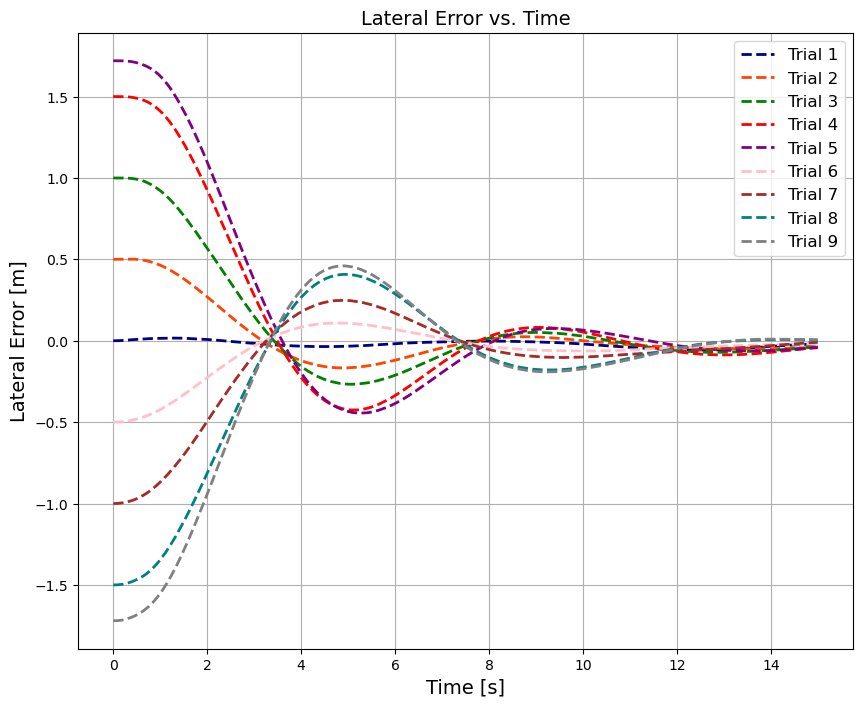

In [165]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

#plots all trials for varying initial lateral errors
axes.plot(data['time'], data['e_lat'], linestyle='dashed', color ='navy', linewidth=2, label="Trial 1")
axes.plot(data2['time'], data2['e_lat'], linestyle='dashed', color='orangered', linewidth=2, label="Trial 2")
axes.plot(data3['time'], data3['e_lat'], linestyle='dashed', color='green', linewidth=2, label="Trial 3")
axes.plot(data4['time'], data4['e_lat'], linestyle='dashed', color='red', linewidth=2, label="Trial 4")
axes.plot(data5['time'], data5['e_lat'], linestyle='dashed', color='purple', linewidth=2, label="Trial 5")
axes.plot(data12['time'], data12['e_lat'], linestyle='dashed', color='pink', linewidth=2, label="Trial 6")
axes.plot(data13['time'], data13['e_lat'], linestyle='dashed', color='brown', linewidth=2, label="Trial 7")
axes.plot(data14['time'], data14['e_lat'], linestyle='dashed', color='teal', linewidth=2, label="Trial 8")
axes.plot(data15['time'], data15['e_lat'], linestyle='dashed', color='gray', linewidth=2, label="Trial 9")
axes.grid()
axes.tick_params(labelsize=10)
axes.set_title("Lateral Error vs. Time", fontsize=14)
axes.set_ylabel('Lateral Error [m]', fontsize=14)
axes.set_xlabel('Time [s]', fontsize=14)
axes.legend(fontsize='large')

plt.show()

The pitch angle vs. time graph illustrates how in each trial, the segbot was able to stabilize itself keeping its pitch angle around 1 degree. This makes sense because the system was originally stabilized around a moving segbot, hence the segbot should reach equilibrium around a non-zero pitch angle.

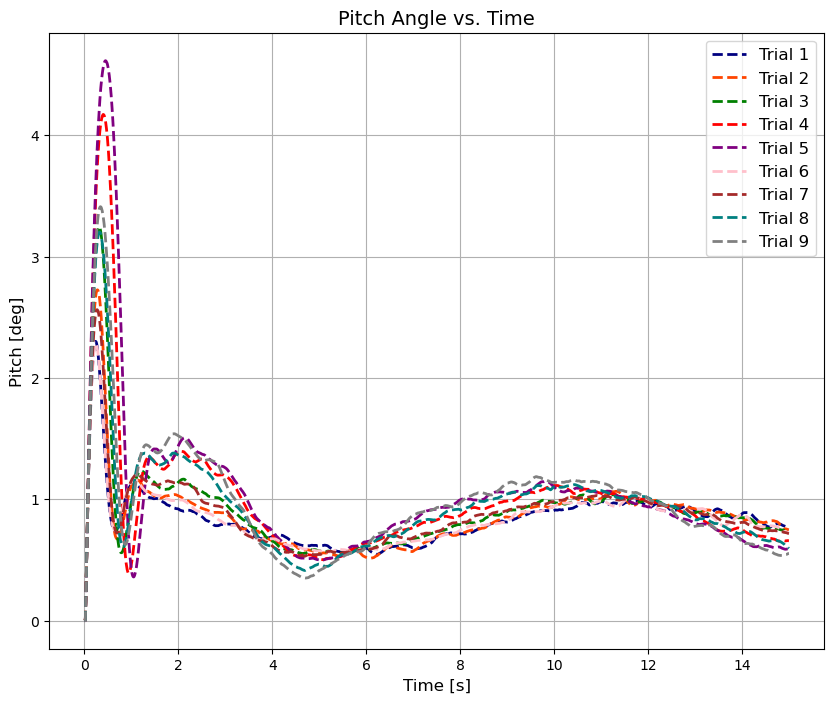

In [164]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

axes.plot(data['time'], np.array(data['theta'])*(180/np.pi), linestyle='dashed', color ='navy', linewidth=2, label="Trial 1")
axes.plot(data2['time'], np.array(data2['theta'])*(180/np.pi), linestyle='dashed', color='orangered', linewidth=2, label="Trial 2")
axes.plot(data3['time'], np.array(data3['theta'])*(180/np.pi), linestyle='dashed', color='green', linewidth=2, label="Trial 3")
axes.plot(data4['time'], np.array(data4['theta'])*(180/np.pi), linestyle='dashed', color='red', linewidth=2, label="Trial 4")
axes.plot(data5['time'], np.array(data5['theta'])*(180/np.pi), linestyle='dashed', color='purple', linewidth=2, label="Trial 5")
axes.plot(data12['time'], np.array(data12['theta'])*(180/np.pi), linestyle='dashed', color='pink', linewidth=2, label="Trial 6")
axes.plot(data13['time'], np.array(data13['theta'])*(180/np.pi), linestyle='dashed', color='brown', linewidth=2, label="Trial 7")
axes.plot(data14['time'], np.array(data14['theta'])*(180/np.pi), linestyle='dashed', color='teal', linewidth=2, label="Trial 8")
axes.plot(data15['time'], np.array(data15['theta'])*(180/np.pi), linestyle='dashed', color='gray', linewidth=2, label="Trial 9")
axes.tick_params(labelsize=10)
axes.set_title("Pitch Angle vs. Time", fontsize=14)
axes.set_ylabel('Pitch [deg]', fontsize=12)
axes.set_xlabel('Time [s]', fontsize=12)
axes.legend(fontsize='large')
axes.grid()

plt.show()

# Simulations for Second Requirement

The parameters for these simulations were also held at a space station angular velocity of -0.1 rad/s and simulation time of 15 seconds. Additionally, the initial lateral error is held at 0 as human commands will now alter the desired target lateral position. In each new simulation, the target lateral position was increased/decreased from 0 meters to specific ranges between +-1.5 meters. The max ranges for the target lateral position were determined to be a safe +-1.5 meters as previously used for the first requirement. The tests were manually done through the PyBullet simulator for 5 trials total. Keyboard interactivity is also utilized for this simulation to control the target lateral position.

## Trials 10-14

In [63]:
#Trial 10
sim6 = ae353_segbot.Segbot_sim(use_keyboard=True, visualization=True, animation=False,  bumpy=False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7014/static/


In [64]:
data6 = sim6.run(controller,
               max_time=15,
               initial_e_lat = 0,
               station_velocity = v_station)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


In [51]:
#Trial 11
sim7 = ae353_segbot.Segbot_sim(use_keyboard=True, visualization=True,   animation=False,  bumpy=False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7007/static/


In [52]:
data7 = sim7.run(controller,
               max_time=15,
               initial_e_lat = 0,
               station_velocity = v_station)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...
PAUSED
RESUME
Termination command detected. Terminating keyboard listener. Goodbye


In [53]:
#Trial 12
sim8 = ae353_segbot.Segbot_sim(use_keyboard=True,  visualization=True, animation=False,  bumpy=False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7008/static/


In [54]:
data8 = sim8.run(controller,
               max_time=15,
               initial_e_lat = 0,
               station_velocity = v_station)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...
Termination command detected. Terminating keyboard listener. Goodbye


In [55]:
#Trial 13
sim9 = ae353_segbot.Segbot_sim(use_keyboard=True, visualization=True, animation=False, bumpy=False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7009/static/


In [56]:
data9 = sim9.run(controller,
               max_time=15,
               initial_e_lat = 0,
               station_velocity = v_station)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...
Termination command detected. Terminating keyboard listener. Goodbye


In [57]:
#Trial 14
sim10 = ae353_segbot.Segbot_sim(use_keyboard=True,
                              visualization=True,
                              animation=False,
                              bumpy=False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7010/static/


In [58]:
data10 = sim10.run(controller,
               max_time=15,
               initial_e_lat = 0,
               station_velocity = v_station)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...
Termination command detected. Terminating keyboard listener. Goodbye


In [59]:
sim11 = ae353_segbot.Segbot_sim(use_keyboard=True,
                              visualization=True,
                              animation=False,
                              bumpy=False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7011/static/


In [60]:
data11 = sim11.run(controller,
               max_time=15,
               initial_e_lat = 0,
               station_velocity = v_station)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...
Termination command detected. Terminating keyboard listener. Goodbye


# Plots for Second Requirement

The target lateral positions were arbitrarily moved using the keyboard commands [(j) - move the target to the left] or [(l) – move the target to the right]. The segbot was able to cover the max range of lateral positions during the 15 second interval [-1.5, 1.5] meters. In Trials 12 and 14, the segbot moved laterally twice. 

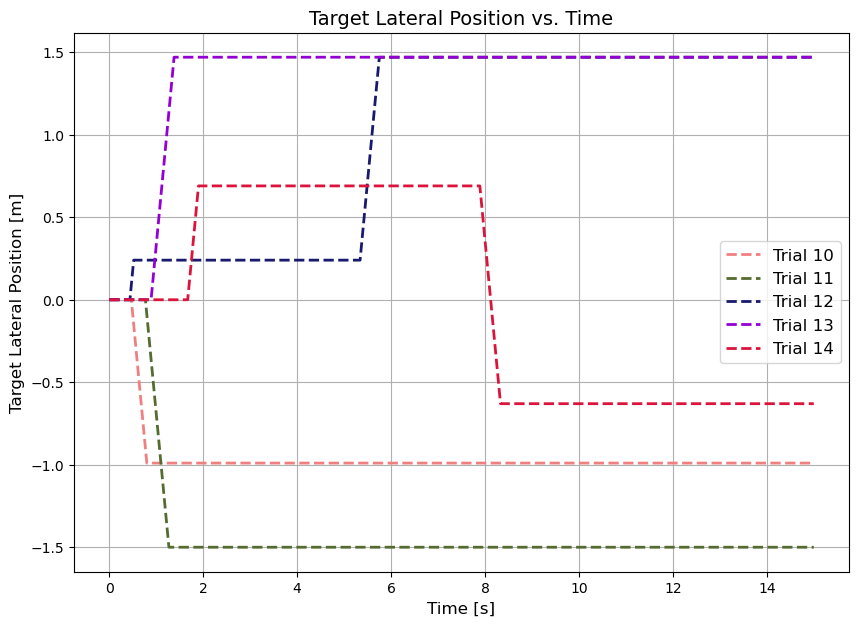

In [170]:
fig, axes = plt.subplots(1, 1, figsize=(10, 7))

# Create a plot of the pitch angle versus time for data
axes.plot(data7['time'], data7['tag_lat'], linestyle='dashed', color ='lightcoral', linewidth=2, label="Trial 10")
axes.plot(data8['time'], data8['tag_lat'], linestyle='dashed', color='darkolivegreen', linewidth=2, label="Trial 11")
axes.plot(data9['time'], data9['tag_lat'], linestyle='dashed', color='midnightblue', linewidth=2, label="Trial 12")
axes.plot(data10['time'], data10['tag_lat'], linestyle='dashed', color='darkviolet', linewidth=2, label="Trial 13")
axes.plot(data11['time'], data11['tag_lat'], linestyle='dashed', color='crimson', linewidth=2, label="Trial 14")
axes.tick_params(labelsize=10)
axes.set_title("Target Lateral Position vs. Time", fontsize=14)
axes.set_ylabel('Target Lateral Position [m]', fontsize=12)
axes.set_xlabel('Time [s]', fontsize=12)
axes.legend(fontsize='large')
axes.grid()
plt.show()

Again, the pitch angle vs. time graph illustrates how in each trial, the segbot was able to stabilize itself as it moved towards the desired lateral target position. While, this time, the pitch angles were more wild and perfect stability was not achieved, each pitch still falls between 0 degrees and 2 degrees, signifying the segbot is still in motion and still vertically upright. The clutter could potentially be attributed to the human command moving the lateral position.

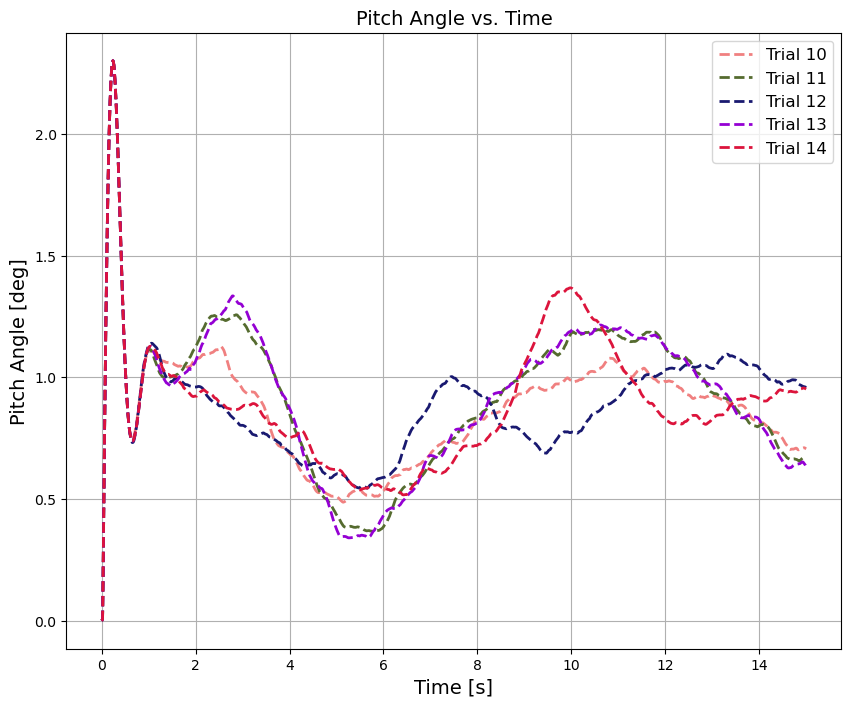

In [171]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

axes.plot(data7['time'], np.array(data7['theta'])*(180/np.pi), linestyle='dashed', color ='lightcoral', linewidth=2, label="Trial 10")
axes.plot(data8['time'], np.array(data8['theta'])*(180/np.pi), linestyle='dashed', color='darkolivegreen', linewidth=2, label="Trial 11")
axes.plot(data9['time'], np.array(data9['theta'])*(180/np.pi), linestyle='dashed', color='midnightblue', linewidth=2, label="Trial 12")
axes.plot(data10['time'], np.array(data10['theta'])*(180/np.pi), linestyle='dashed', color='darkviolet', linewidth=2, label="Trial 13")
axes.plot(data11['time'], np.array(data11['theta'])*(180/np.pi), linestyle='dashed', color='crimson', linewidth=2, label="Trial 14")
axes.grid()
axes.tick_params(labelsize=10)
axes.set_title("Pitch Angle vs. Time", fontsize=14)
axes.set_ylabel('Pitch Angle [deg]', fontsize=14)
axes.set_xlabel('Time [s]', fontsize=14)
axes.legend(fontsize='large')
plt.show()